# ML Project Notebook

In [1]:
from pathlib import Path
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt

from shapely.geometry import Point
import geopandas as gpd
import xgboost as xgb

import fastai.tabular.all as ft
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics

In [2]:
DATA_DIR = Path("datasets")
!ls {DATA_DIR}

SubmissionFormat.csv  TestData.csv  TrainData.csv  TrainLabels.csv


In [3]:
df_train_points = pd.read_csv(DATA_DIR/'TrainData.csv')
df_train_labels = pd.read_csv(DATA_DIR/'TrainLabels.csv')
df_test_points = pd.read_csv(DATA_DIR/'TestData.csv')
df_points = pd.concat([df_train_points, df_test_points])
df = df_points.merge(df_train_labels, left_on="id", right_on="id", how="outer")

In [4]:
df['date_recorded'] = pd.to_datetime(df['date_recorded'], format='%Y-%m-%d')
df.head()

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,...,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group
0,69572,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,0,...,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe,functional
1,8776,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,...,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional
2,34310,25.0,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,...,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe,functional
3,67743,0.0,2013-01-28,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,0,...,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe,non functional
4,19728,0.0,2011-07-13,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,0,...,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional


## Helper Functions

In [5]:
def correlation_to_cts(df, cts_col):
    df_dummies = pd.get_dummies(df['status_group'])
    df_new = pd.concat([df, df_dummies], axis=1)
    df_check = df_new[[cts_col, 'functional', 'functional needs repair', 'non functional']]
    sns.heatmap(df_check.corr())

In [6]:
def standardize(values):
    return (values - values.mean()) / values.std()

In [7]:
def label_encode(series, low_count=None):
    series = series.copy()

    if low_count:
        # assume str type if low count is present
        low_vals = [k for k, v in series.value_counts().items() if v < low_count]
        series = series.replace({val:'#NA#' for val in low_vals})

    labelencoder = LabelEncoder()
    encoded = labelencoder.fit_transform(series).astype(int)
    return encoded, labelencoder.classes_

In [8]:
def clean_text(series):
    series_filled = series.fillna('#na#')
    series_lowered = series_filled.str.lower()
    series_replaced = series_lowered.str.replace(r"[^\w\s]", "", regex=True)
    print(f"Reduced {len(series_filled.unique())} to {len(series_replaced.unique())} columns")
    return series_replaced

def replace_phrase(series, phrases):
    series = clean_text(series)
    new_vals = []
    for val in series:
        for phrase in phrases:
            if phrase in val:
                new_vals.append(phrase)
                break
        else:
            new_vals.append(val)
    return pd.Series(new_vals)

In [9]:
replace_phrase(df['funder'], ['gover', 'church', 'comm', 'coun', 'kkkt', 'tcrs', 'islam', 'musl', 'hesa', 'germ']).value_counts()

Reduced 2141 to 2141 columns


gover                  11609
na                      4504
danida                  3907
hesa                    2799
kkkt                    1863
                       ...  
dwsdp                      1
subvillage                 1
holili water supply        1
duka                       1
velem                      1
Length: 1950, dtype: int64

## Exploratory Data Analysis

In [10]:
df.columns

Index(['id', 'amount_tsh', 'date_recorded', 'funder', 'gps_height',
       'installer', 'longitude', 'latitude', 'wpt_name', 'num_private',
       'basin', 'subvillage', 'region', 'region_code', 'district_code', 'lga',
       'ward', 'population', 'public_meeting', 'recorded_by',
       'scheme_management', 'scheme_name', 'permit', 'construction_year',
       'extraction_type', 'extraction_type_group', 'extraction_type_class',
       'management', 'management_group', 'payment', 'payment_type',
       'water_quality', 'quality_group', 'quantity', 'quantity_group',
       'source', 'source_type', 'source_class', 'waterpoint_type',
       'waterpoint_type_group', 'status_group'],
      dtype='object')

<AxesSubplot:xlabel='count', ylabel='status_group'>

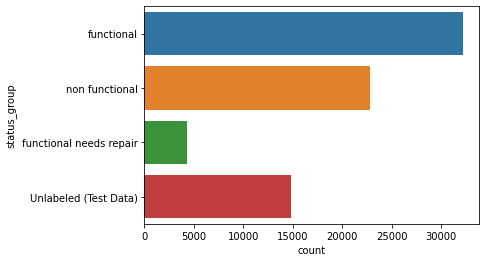

In [11]:
sns.countplot(data=df.fillna("Unlabeled (Test Data)"), y="status_group")

### Missing Values

In [12]:
(df.isna()
    .sum()
    .to_frame('missing_count')
    .assign(missing_ratio = lambda x: x['missing_count']/len(df))
    .loc[df.isna().any()])

,missing_count,missing_ratio
funder,4504,0.060660
installer,4532,0.061037
subvillage,470,0.006330
public_meeting,4155,0.055960
scheme_management,4846,0.065266
scheme_name,35258,0.474855
permit,3793,0.051084
status_group,14850,0.200000


In [13]:
((df == 0)
    .sum(axis=0)
    .to_frame('zero_count')
    .assign(zero_ratio = lambda x: x['zero_count']/len(df))
    .loc[(df == 0).sum(axis=0) > 0])

,zero_count,zero_ratio
id,1,0.000013
amount_tsh,52049,0.700997
gps_height,25649,0.345441
longitude,2269,0.030559
num_private,73299,0.987192
district_code,27,0.000364
population,26834,0.361401
public_meeting,6346,0.085468
permit,21851,0.294290
construction_year,25969,0.349751


In below titles (Z) indicates that the column has an unusual amount of zero values, and (M) if it has missing values.

### Amount tsh

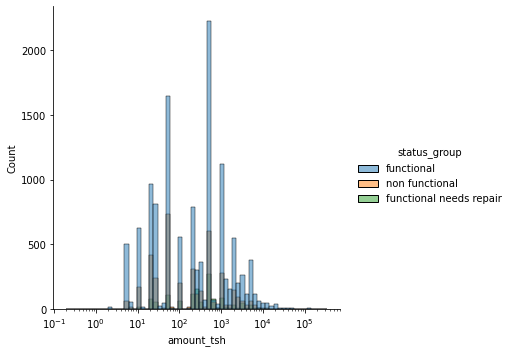

In [14]:
sns.displot(data=df[df['amount_tsh'] > 0], x='amount_tsh', log_scale=True, hue='status_group')

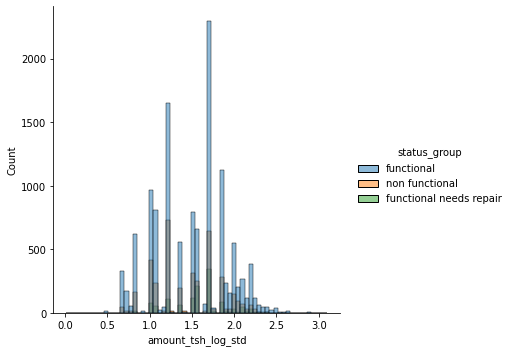

In [15]:
df_ = df.copy()
df_['amount_tsh_missing'] = (df_['amount_tsh'] == 0).astype(int)
df_['amount_tsh_log_std'] = standardize(np.log(df_['amount_tsh'] + 0.01))
sns.displot(data=df_[df_['amount_tsh_missing'] == 0], x='amount_tsh_log_std', hue='status_group')

<AxesSubplot:xlabel='amount_tsh_missing', ylabel='count'>

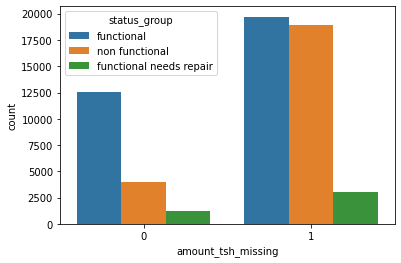

In [16]:
sns.countplot(data=df_, x='amount_tsh_missing', hue='status_group')

### Date Recorded

Add additional column so we can group by the year-month combination easily. Then find the percentage of functional/non functional/need repair in each month.
If this is mostly constant, we can assume date recorded to not have any effect on target.

In [17]:
df_ = df.copy()
df_['date_recorded_ym'] = df_['date_recorded'].map(lambda d: d.year*12 + d.month)

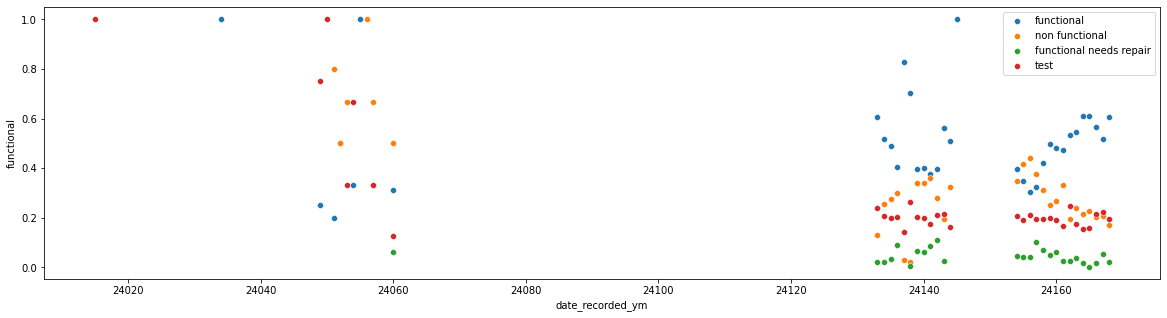

In [18]:
df_['status_group'] = df_['status_group'].fillna('test')
df__ = df_.groupby('date_recorded_ym')['status_group'].value_counts(normalize=True).unstack()
fig = plt.figure(figsize=(20,5))
ax = plt.subplot()
sns.scatterplot(data=df__, y='functional', x='date_recorded_ym', ax=ax, label='functional')
sns.scatterplot(data=df__, y='non functional', x='date_recorded_ym', ax=ax, label='non functional')
sns.scatterplot(data=df__, y='functional needs repair', x='date_recorded_ym', ax=ax, label='functional needs repair')
sns.scatterplot(data=df__, y='test', x='date_recorded_ym', ax=ax, label='test')
del df__

There seems to be only a few date recorded clusters. So we can combine them to 3 groups. `A < 24080 < B < 24150 < C`

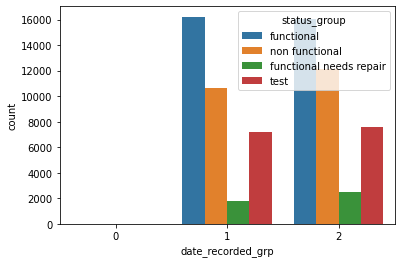

In [19]:
df_['date_recorded_grp'] = 2
df_.loc[df_['date_recorded_ym'] < 24150, 'date_recorded_grp'] = 1
df_.loc[df_['date_recorded_ym'] < 24080, 'date_recorded_grp'] = 0

ax = sns.countplot(data=df_, x='date_recorded_grp', hue='status_group')

So there does not seem to much of an effect of date_recorded.

### Funder

To reduce the cardinality, we can remove funders with less than 20 fundings. (Mark them as Other)

/home/kdsuneraavinash/.virtualenvs/ml-project-pump-it-up/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='funder', ylabel='count'>

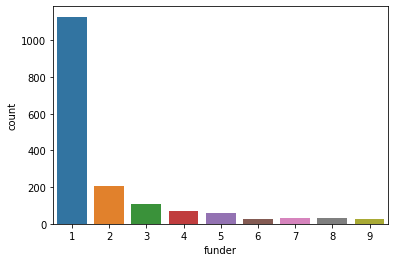

In [20]:
val_counts = df['funder'].value_counts()
val_counts = val_counts[val_counts < 10]
sns.countplot(val_counts)

In [21]:
df_ = df.copy()
df_.loc[df_.groupby('funder').funder.transform('count').lt(100), 'funder'] = pd.NA

df_['funder'].value_counts()

Government Of Tanzania    11299
Danida                     3907
Hesawa                     2782
Rwssp                      1703
World Bank                 1701
                          ...  
Undp                        103
Rc Ch                       103
Missi                       102
Gtz                         102
H                           102
Name: funder, Length: 101, dtype: int64

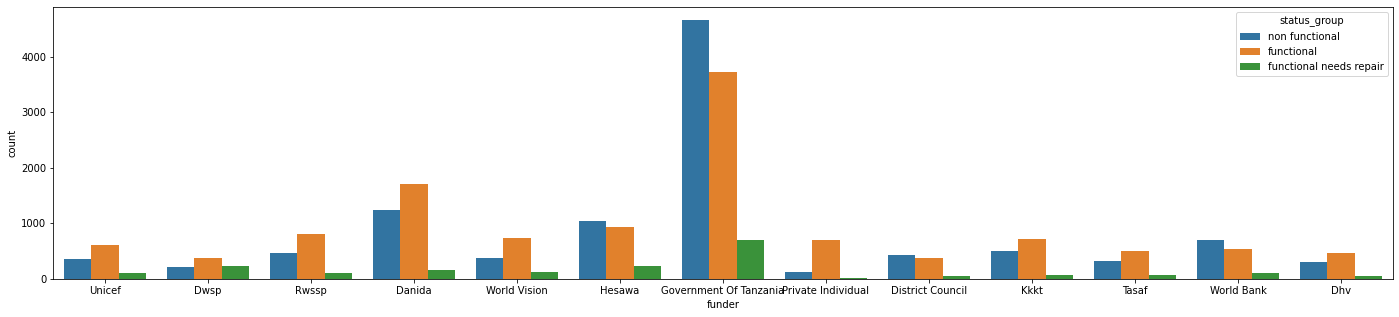

In [22]:
# Plot all the funders with 1000
df__ = df_[df_.groupby('funder').funder.transform('count').gt(1000)]

fig = plt.figure(figsize=(24,5))
ax = plt.subplot()
sns.countplot(data=df__, x='funder', hue='status_group', ax=ax)

del df__

### GPS Height

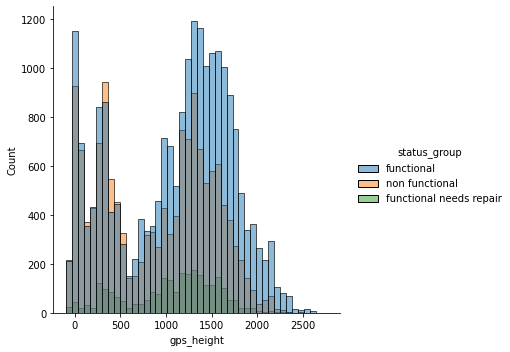

In [23]:
sns.displot(data=df[df.gps_height != 0], x="gps_height", hue="status_group")

The zero values in this column seems to be real data and not missing values.

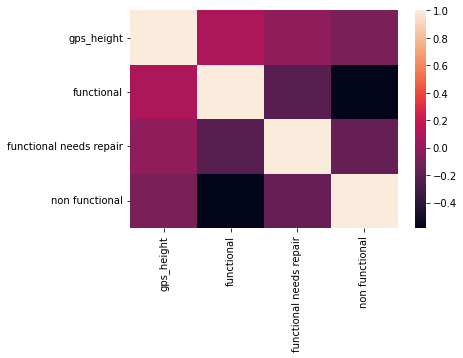

In [24]:
correlation_to_cts(df, 'gps_height')

### Installer

/home/kdsuneraavinash/.virtualenvs/ml-project-pump-it-up/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='installer', ylabel='count'>

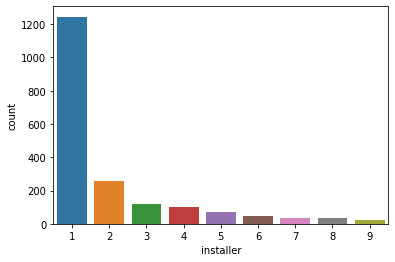

In [25]:
val_counts = df['installer'].value_counts()
val_counts = val_counts[val_counts < 10]
sns.countplot(val_counts)

In [26]:
df_ = df.copy()

df_.loc[df_['installer'] == '-', 'installer'] = pd.NA
df_.loc[df_['installer'] == '0', 'installer'] = pd.NA
df_.loc[df_.groupby('funder').funder.transform('count').lt(100), 'funder'] = pd.NA
df_['installer'] = df_['installer'].fillna('Other')

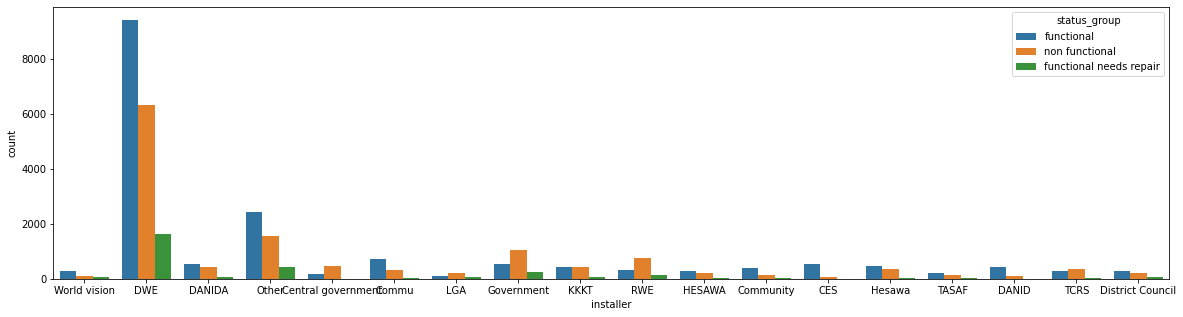

In [27]:
df__ = df_[df_.groupby('installer').installer.transform('count').gt(500)]
fig = plt.figure(figsize=(20,5))
sns.countplot(data=df__, x='installer', hue='status_group')
del df__

### Longitude and latitude

In [28]:
geometry = [Point(xy) for xy in zip(df["longitude"], df["latitude"])]
geo_df = gpd.GeoDataFrame(df, crs={'init': 'epsg:4326'}, geometry=geometry)
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
africa = world.query('continent == "Africa"')

/home/kdsuneraavinash/.virtualenvs/ml-project-pump-it-up/lib/python3.9/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


<AxesSubplot:>

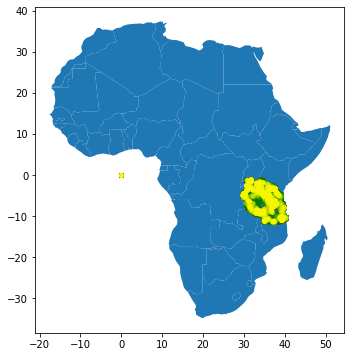

In [29]:
ax = africa.plot(figsize=(10, 6))
geo_df[geo_df.status_group == "non functional"].plot(ax=ax, marker='o', color='red', markersize=15, alpha=0.2)
geo_df[geo_df.status_group == "functional"].plot(ax=ax, marker='o', color='green', markersize=15, alpha=0.4)
geo_df[geo_df.status_group == "functional needs repair"].plot(ax=ax, marker='o', color='yellow', markersize=15, alpha=0.1)

Let's remove all the unrelated points.

<AxesSubplot:>

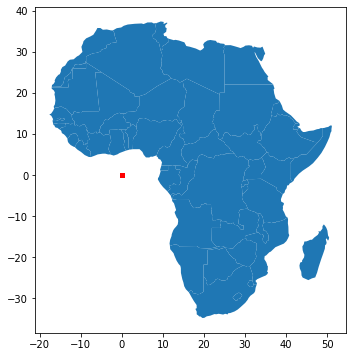

In [30]:
ax = africa.plot(figsize=(10, 6))
geo_df[(geo_df.latitude < 10) & (geo_df.longitude < 10)].plot(ax=ax, marker='o', color='red', markersize=15, alpha=0.2)

<AxesSubplot:xlabel='longitude', ylabel='latitude'>

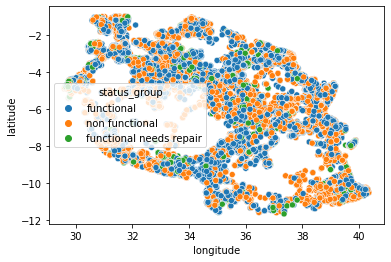

In [31]:
df_ = df[((df.latitude > 10) | (df.longitude > 10))].copy()
sns.scatterplot(data=df_, x="longitude", y="latitude", hue="status_group")

<AxesSubplot:>

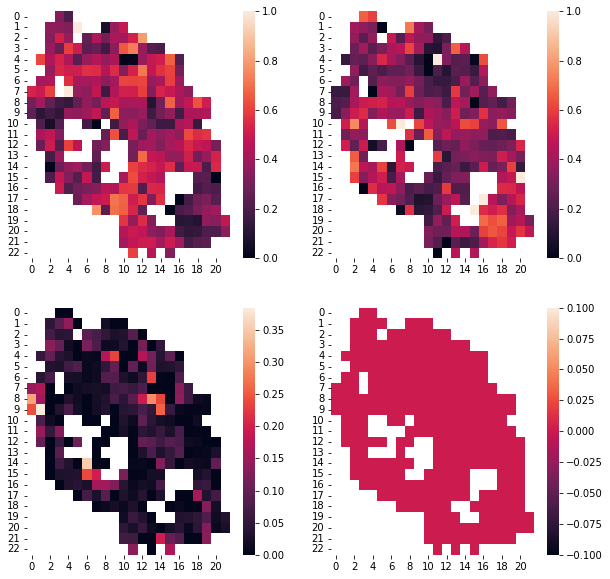

In [32]:
df_ = df[((df.latitude > 10) | (df.longitude > 10))].copy()
df_["latbin"] = df_.latitude.map(lambda x: np.floor(-x*2))
df_["lonbin"] = df_.longitude.map(lambda x: np.floor(x*2))

df_['status_group_functional'] = 0
df_['status_group_non_functional'] = 0
df_['status_group_functional_needs_repair'] = 0
df_['status_group_test'] = 0
df_.loc[df_['status_group'] == 'functional', 'status_group_functional'] = 1
df_.loc[df_['status_group'] == 'non functional', 'status_group_non_functional'] = 1
df_.loc[df_['status_group'] == 'functional needs repair', 'status_group_functional_needs_repair'] = 1
df_.loc[df_['status_group'] == pd.NA, 'status_group_test'] = 1

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 10))
axes = axes.flatten()
sns.heatmap(df_[['lonbin', 'latbin', 'status_group_functional']].groupby(['lonbin', 'latbin'])['status_group_functional'].mean().unstack().T.values, ax=axes[0])
sns.heatmap(df_[['lonbin', 'latbin', 'status_group_non_functional']].groupby(['lonbin', 'latbin'])['status_group_non_functional'].mean().unstack().T.values, ax=axes[1])
sns.heatmap(df_[['lonbin', 'latbin', 'status_group_functional_needs_repair']].groupby(['lonbin', 'latbin'])['status_group_functional_needs_repair'].mean().unstack().T.values, ax=axes[2])
sns.heatmap(df_[['lonbin', 'latbin', 'status_group_test']].groupby(['lonbin', 'latbin'])['status_group_test'].mean().unstack().T.values, ax=axes[3])

### WPT Name

In [33]:
df['wpt_name'].value_counts()

none                      4440
Shuleni                   2183
Zahanati                  1034
Msikitini                  647
Kanisani                   390
                          ... 
Shule Ya Msingi Bitale       1
Isyeto                       1
Kituo Cha Liheta             1
Kwa Juma Lukanda             1
Kwa Mzee Chagala             1
Name: wpt_name, Length: 45684, dtype: int64

<AxesSubplot:xlabel='wpt_name', ylabel='count'>

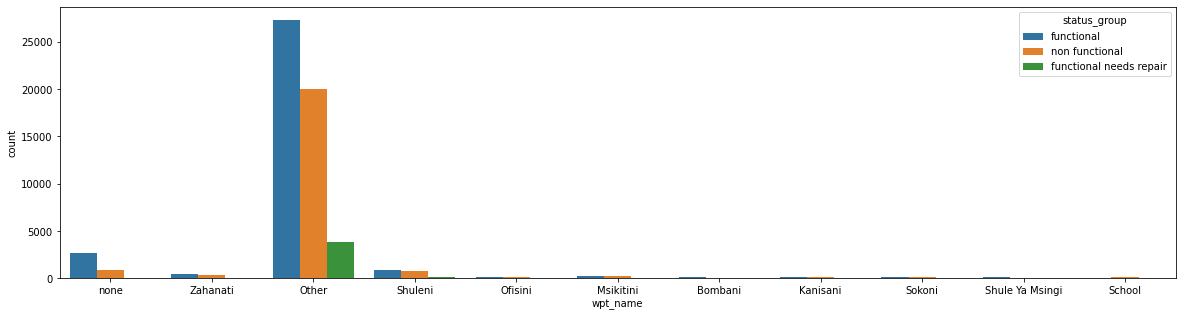

In [34]:
df_ = df.copy()
df_.loc[df_.groupby('wpt_name').wpt_name.transform('count').lt(200), 'wpt_name'] = pd.NA
df_['wpt_name'] = df_['wpt_name'].fillna('Other')

plt.figure(figsize=(20,5))
sns.countplot(data=df_, x='wpt_name', hue='status_group')

### Num Private

<Figure size 1440x360 with 0 Axes>

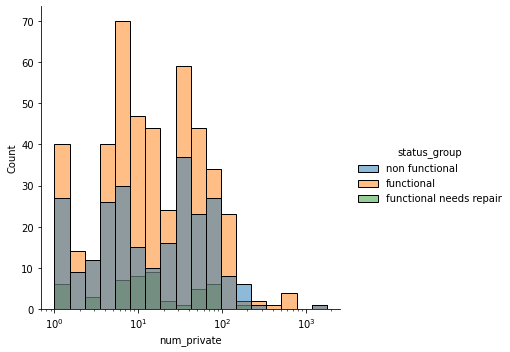

In [35]:
plt.figure(figsize=(20,5))
sns.displot(data=df[df.num_private != 0], x='num_private', hue='status_group', log_scale=True)

<AxesSubplot:xlabel='num_private_zero', ylabel='count'>

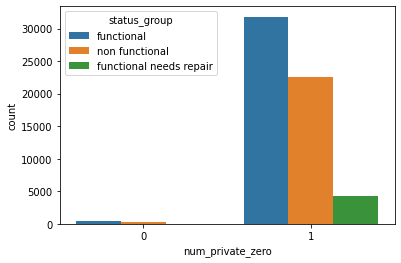

In [36]:
df_ = df.copy()
df_['num_private_zero'] = (df.num_private == 0).astype(int)
sns.countplot(data=df_, x='num_private_zero', hue='status_group')

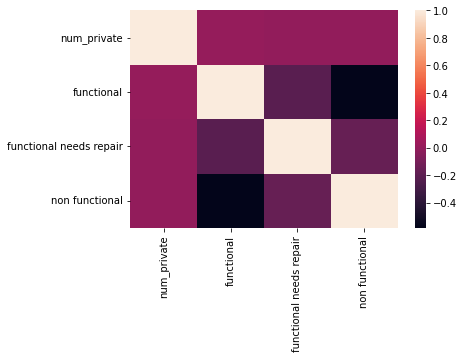

In [37]:
correlation_to_cts(df, 'num_private')

### Basin

<AxesSubplot:xlabel='basin', ylabel='count'>

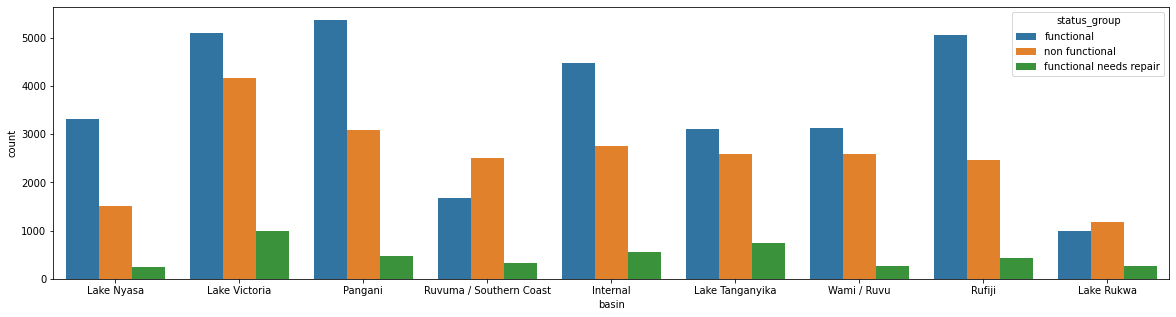

In [38]:
plt.figure(figsize=(20,5))
sns.countplot(data=df, x='basin', hue='status_group')

### Region and region code

In [39]:
print("Region codes: ", df['region_code'].unique())
print("Regions: ", df['region'].unique())
df.groupby(['region_code', 'region'])['id'].count()

Region codes:  [11 20 21 90 18  4 17 14 60 10  3 15 19 16 80  1  6  2 12 13  5  7 99 24
  9  8 40]
Regions:  ['Iringa' 'Mara' 'Manyara' 'Mtwara' 'Kagera' 'Tanga' 'Shinyanga' 'Tabora'
 'Pwani' 'Ruvuma' 'Kilimanjaro' 'Rukwa' 'Mwanza' 'Kigoma' 'Lindi' 'Dodoma'
 'Arusha' 'Mbeya' 'Singida' 'Morogoro' 'Dar es Salaam']


region_code  region       
1            Dodoma           2779
2            Arusha           3709
3            Kilimanjaro      5494
4            Tanga            3145
5            Morogoro         5038
             Tanga              41
6            Pwani            2032
7            Dar es Salaam    1020
8            Lindi             375
9            Mtwara            499
10           Ruvuma           3306
11           Iringa           6599
             Shinyanga           9
12           Mbeya            5758
             Mwanza              1
13           Singida          2536
14           Shinyanga          22
             Tabora           2466
15           Rukwa            2242
16           Kigoma           3533
17           Mwanza             72
             Shinyanga        6262
18           Kagera           4174
             Lindi               9
19           Mwanza           3824
20           Mara             2451
21           Manyara          1972
24           Arusha         

<AxesSubplot:xlabel='region', ylabel='count'>

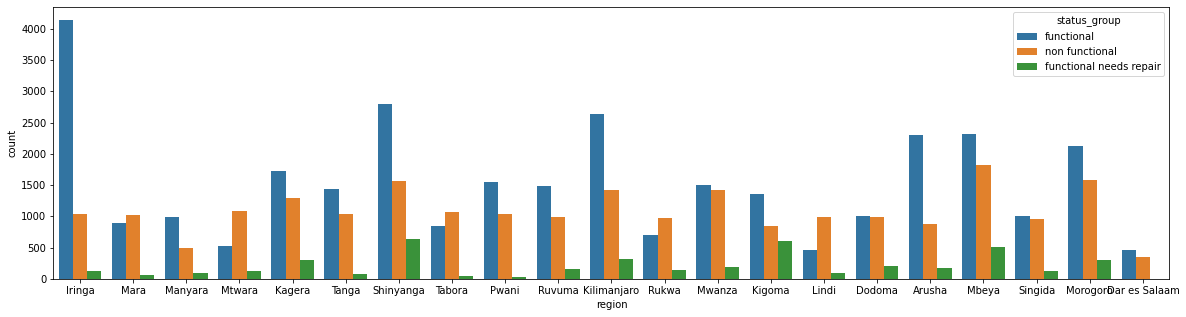

In [40]:
plt.figure(figsize=(20,5))
sns.countplot(data=df, x='region', hue='status_group')

Both seems to be mosltly the same. So lets consider region only.

### Sub Village

In [41]:
df['subvillage'].value_counts()

Shuleni       646
Majengo       631
Madukani      629
Kati          467
Mtakuja       322
             ... 
Kalipinde       1
Isimikine       1
Bukiliguru      1
Busulilo        1
Kosoro          1
Name: subvillage, Length: 21425, dtype: int64

### District code

<AxesSubplot:xlabel='district_code', ylabel='count'>

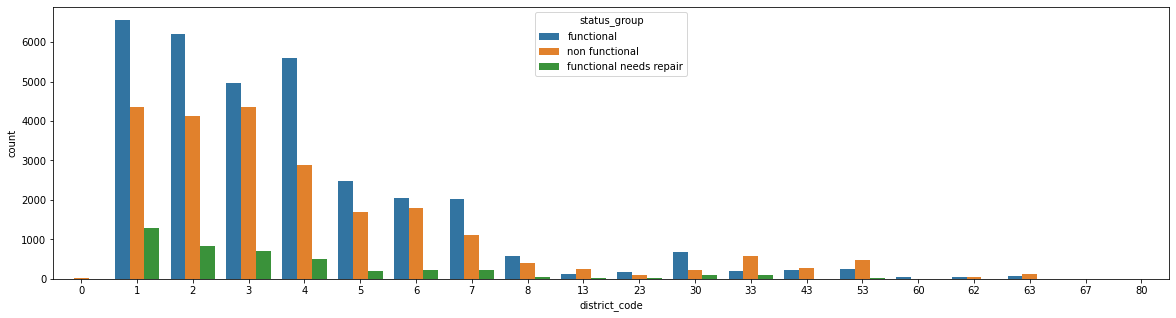

In [42]:
plt.figure(figsize=(20,5))
sns.countplot(data=df, x='district_code', hue='status_group')

### LGA and Ward

In [43]:
print("Ward: ", len(df['ward'].unique()))
print("LGA: ", len(df['lga'].unique()))

Ward:  2098
LGA:  125


In [44]:
df['ward'].value_counts()

Igosi              386
Imalinyi           318
Siha Kati          297
Mdandu             292
Nduruma            261
                  ... 
Rasbura              1
Matarawe             1
Themi                1
Uwanja wa Ndege      1
Mwalugulu            1
Name: ward, Length: 2098, dtype: int64

In [45]:
df['lga'].value_counts()

Njombe          3128
Moshi Rural     1566
Arusha Rural    1521
Bariadi         1485
Rungwe          1381
                ... 
Songea Urban     103
Kigoma Urban      95
Arusha Urban      82
Lindi Urban       24
Nyamagana          2
Name: lga, Length: 125, dtype: int64

### Public meeting

<AxesSubplot:xlabel='public_meeting', ylabel='count'>

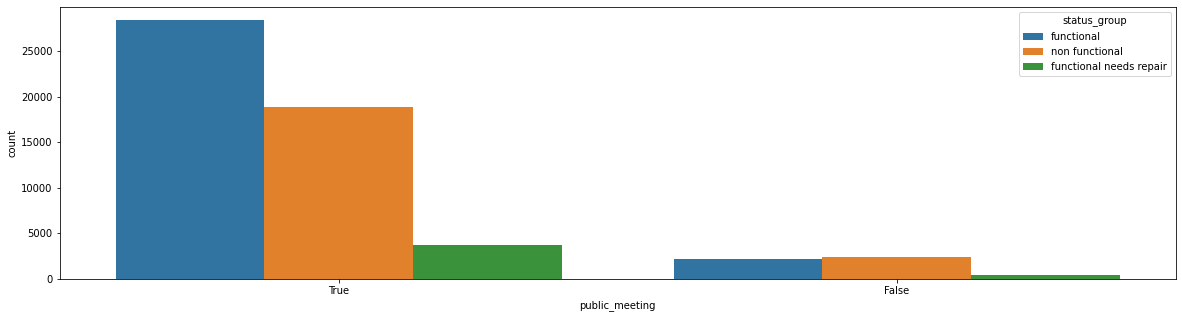

In [46]:
plt.figure(figsize=(20,5))
sns.countplot(data=df, x='public_meeting', hue='status_group')

### Recorded By

In [47]:
print("Recorded By: ", df['recorded_by'].unique())

Recorded By:  ['GeoData Consultants Ltd']


### Permit

<AxesSubplot:xlabel='permit', ylabel='count'>

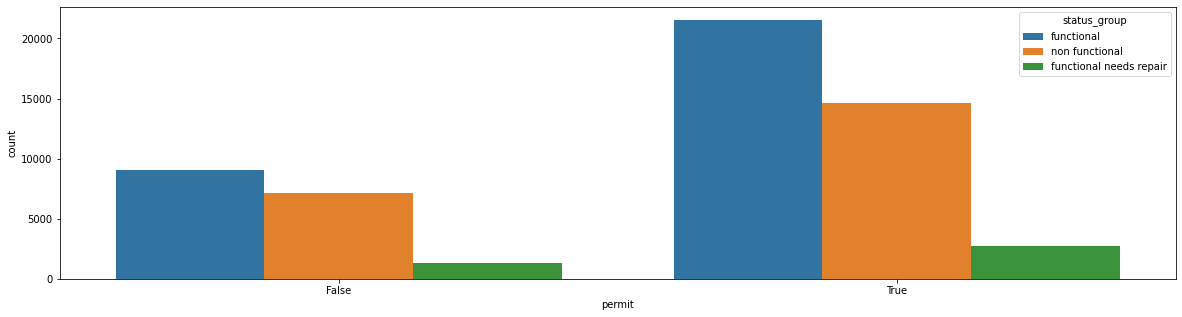

In [48]:
plt.figure(figsize=(20,5))
sns.countplot(data=df, x='permit', hue='status_group')

### Scheme Management and Scheme Name

In [49]:
print("Scheme Name: ", df['scheme_name'].unique())
print("Scheme Management: ", df['scheme_management'].unique())
df.groupby(['scheme_management'])['id'].count()

Scheme Name:  ['Roman' nan 'Nyumba ya mungu pipe scheme' ... 'Grumeti' 'BL Vetenary'
 'MIGA']
Scheme Management:  ['VWC' 'Other' nan 'Private operator' 'WUG' 'Water Board' 'WUA'
 'Water authority' 'Company' 'Parastatal' 'Trust' 'SWC' 'None']


scheme_management
Company              1341
None                    1
Other                 996
Parastatal           2124
Private operator     1326
SWC                   123
Trust                  92
VWC                 45917
WUA                  3551
WUG                  6496
Water Board          3462
Water authority      3975
Name: id, dtype: int64

<AxesSubplot:xlabel='scheme_management', ylabel='count'>

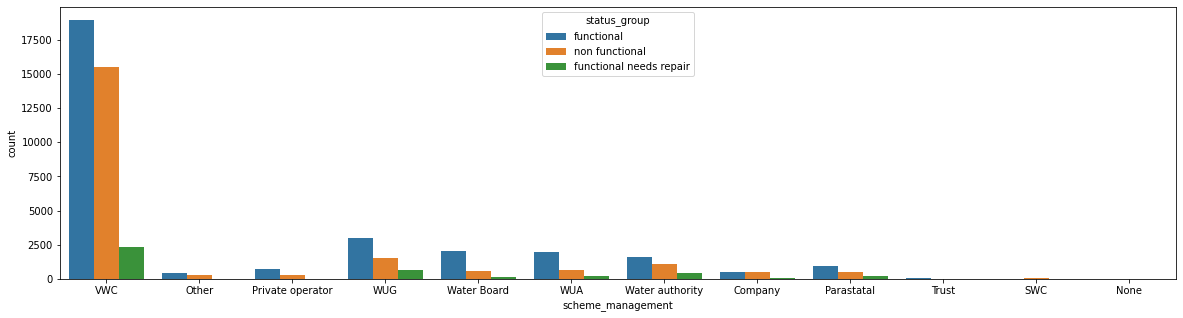

In [50]:
plt.figure(figsize=(20,5))
sns.countplot(data=df, x='scheme_management', hue='status_group')

### Population

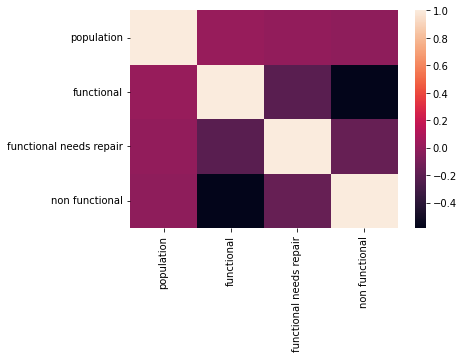

In [51]:
correlation_to_cts(df, 'population')

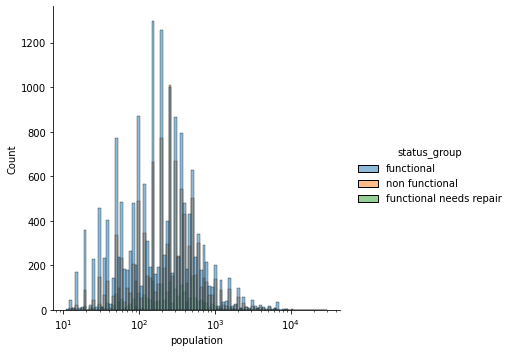

In [52]:
sns.displot(data=df[df['population'] > 10], x='population', log_scale=True, hue='status_group')

### Construction year

In [53]:
df_ = df.copy()
df_['construction_year'] = df_['construction_year'].map(lambda y: 1970 if 0 < y < 1970 else y)

<AxesSubplot:xlabel='construction_year', ylabel='count'>

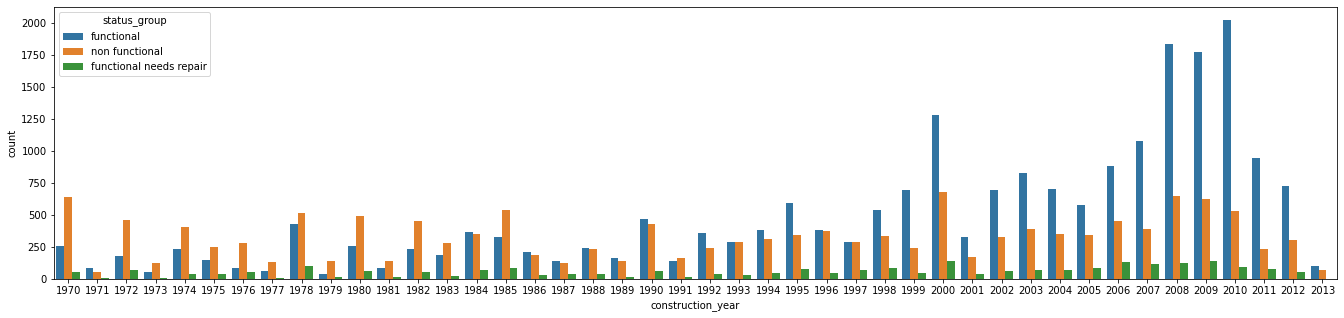

In [54]:
plt.figure(figsize=(23,5))
sns.countplot(data=df_[df_['construction_year'] != 0], x='construction_year', hue='status_group')

### Extraction type, Extraction type group and Extraction type class

In [55]:
print("Extraction types: ", df['extraction_type'].unique())
print("Extraction type groups: ", df['extraction_type_group'].unique())
print("Extraction type classes: ", df['extraction_type_class'].unique())
df.groupby(['extraction_type_class', 'extraction_type_group', 'extraction_type'])['id'].count()

Extraction types:  ['gravity' 'submersible' 'swn 80' 'nira/tanira' 'india mark ii' 'other'
 'ksb' 'mono' 'windmill' 'afridev' 'other - rope pump' 'india mark iii'
 'other - swn 81' 'other - play pump' 'cemo' 'climax' 'walimi'
 'other - mkulima/shinyanga']
Extraction type groups:  ['gravity' 'submersible' 'swn 80' 'nira/tanira' 'india mark ii' 'other'
 'mono' 'wind-powered' 'afridev' 'rope pump' 'india mark iii'
 'other handpump' 'other motorpump']
Extraction type classes:  ['gravity' 'submersible' 'handpump' 'other' 'motorpump' 'wind-powered'
 'rope pump']


extraction_type_class  extraction_type_group  extraction_type          
gravity                gravity                gravity                      33263
handpump               afridev                afridev                       2208
                       india mark ii          india mark ii                 3029
                       india mark iii         india mark iii                 135
                       nira/tanira            nira/tanira                  10205
                       other handpump         other - mkulima/shinyanga        2
                                              other - play pump              101
                                              other - swn 81                 284
                                              walimi                          60
                       swn 80                 swn 80                        4588
motorpump              mono                   mono                          3628
                       other motorpum

<AxesSubplot:xlabel='extraction_type', ylabel='count'>

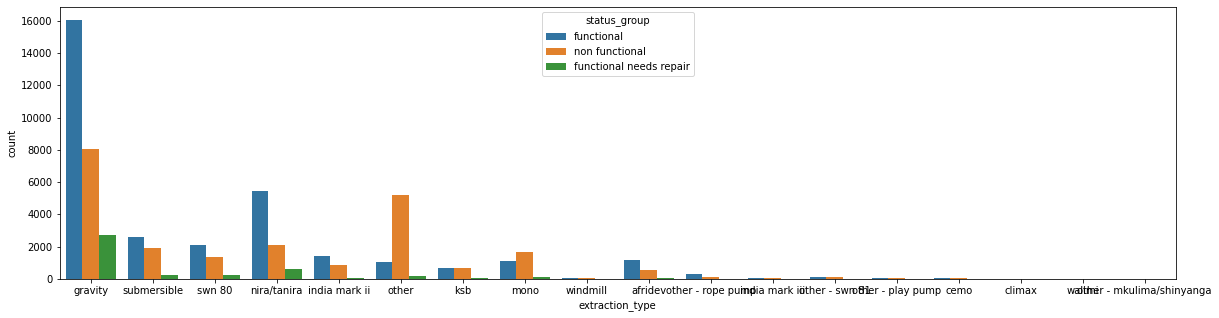

In [56]:
plt.figure(figsize=(20,5))
sns.countplot(data=df, x='extraction_type', hue='status_group')

### Management and management group

In [57]:
print("Managements: ", df['management'].unique())
print("Management Groups: ", df['management_group'].unique())
df.groupby(['management_group', 'management'])['id'].count()

Managements:  ['vwc' 'wug' 'other' 'private operator' 'water board' 'wua' 'company'
 'water authority' 'parastatal' 'unknown' 'other - school' 'trust']
Management Groups:  ['user-group' 'other' 'commercial' 'parastatal' 'unknown']


management_group  management      
commercial        company               859
                  private operator     2504
                  trust                 105
                  water authority      1123
other             other                1083
                  other - school        126
parastatal        parastatal           2229
unknown           unknown               683
user-group        vwc                 50624
                  water board          3688
                  wua                  3118
                  wug                  8108
Name: id, dtype: int64

<AxesSubplot:xlabel='management', ylabel='count'>

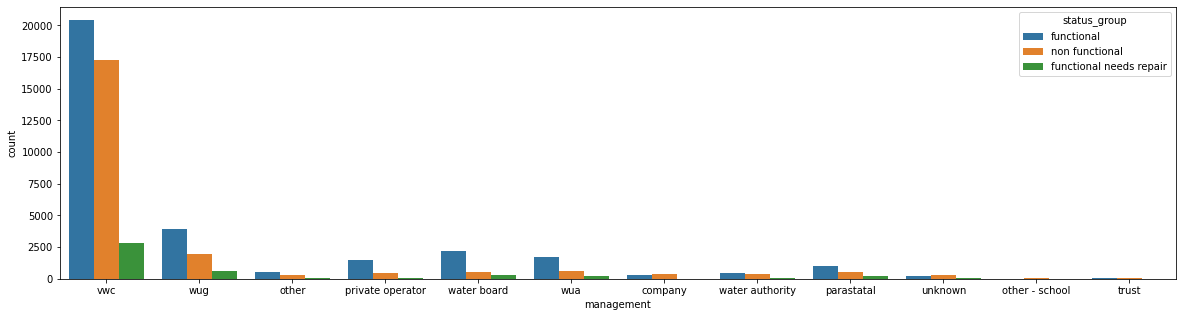

In [58]:
plt.figure(figsize=(20,5))
sns.countplot(data=df, x='management', hue='status_group')

### Payment and payment type

In [59]:
print("Payments: ", df['payment'].unique())
print("Payment Types: ", df['payment_type'].unique())
df.groupby(['payment_type', 'payment'])['id'].count()

Payments:  ['pay annually' 'never pay' 'pay per bucket' 'unknown'
 'pay when scheme fails' 'other' 'pay monthly']
Payment Types:  ['annually' 'never pay' 'per bucket' 'unknown' 'on failure' 'other'
 'monthly']


payment_type  payment              
annually      pay annually              4570
monthly       pay monthly              10397
never pay     never pay                31712
on failure    pay when scheme fails     4842
other         other                     1314
per bucket    pay per bucket           11266
unknown       unknown                  10149
Name: id, dtype: int64

<AxesSubplot:xlabel='payment', ylabel='count'>

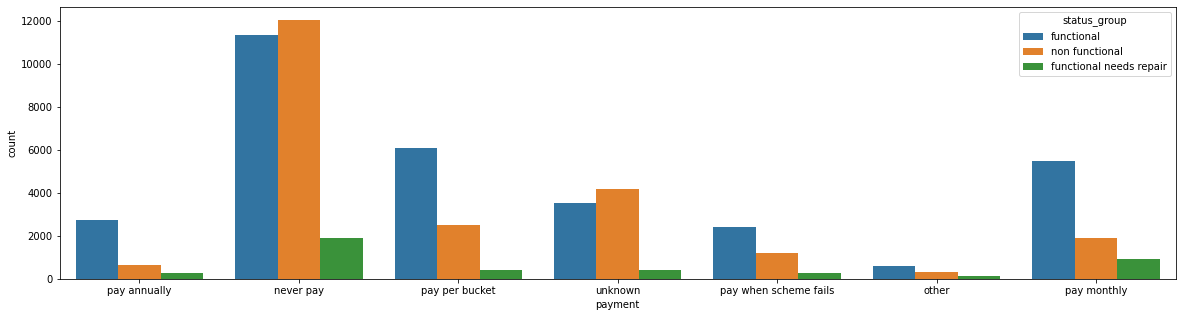

In [60]:
plt.figure(figsize=(20,5))
sns.countplot(data=df, x='payment', hue='status_group')

### Water Quality and Quality Group

In [61]:
print("Water Qualities: ", df['water_quality'].unique())
print("Quality Groups: ", df['quality_group'].unique())
df.groupby(['quality_group', 'water_quality'])['id'].count()

Water Qualities:  ['soft' 'salty' 'milky' 'unknown' 'fluoride' 'coloured' 'salty abandoned'
 'fluoride abandoned']
Quality Groups:  ['good' 'salty' 'milky' 'unknown' 'fluoride' 'colored']


quality_group  water_quality     
colored        coloured                623
fluoride       fluoride                244
               fluoride abandoned       23
good           soft                  63505
milky          milky                  1005
salty          salty                  6082
               salty abandoned         423
unknown        unknown                2345
Name: id, dtype: int64

<AxesSubplot:xlabel='water_quality', ylabel='count'>

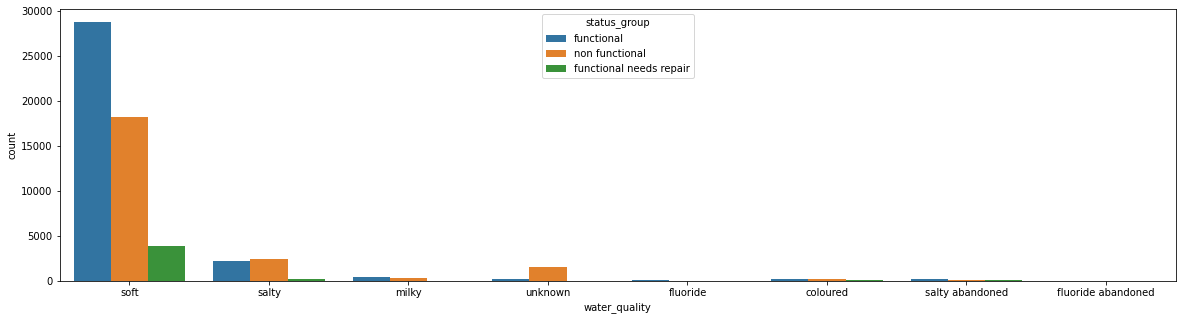

In [62]:
plt.figure(figsize=(20,5))
sns.countplot(data=df, x='water_quality', hue='status_group')

### Quantity and Quantity group

In [63]:
print("Quantities: ", df['quantity'].unique())
print("Quantity Groups: ", df['quantity_group'].unique())
df.groupby(['quantity_group', 'quantity'])['id'].count()

Quantities:  ['enough' 'insufficient' 'dry' 'seasonal' 'unknown']
Quantity Groups:  ['enough' 'insufficient' 'dry' 'seasonal' 'unknown']


quantity_group  quantity    
dry             dry              7782
enough          enough          41522
insufficient    insufficient    18896
seasonal        seasonal         5075
unknown         unknown           975
Name: id, dtype: int64

<AxesSubplot:xlabel='quantity', ylabel='count'>

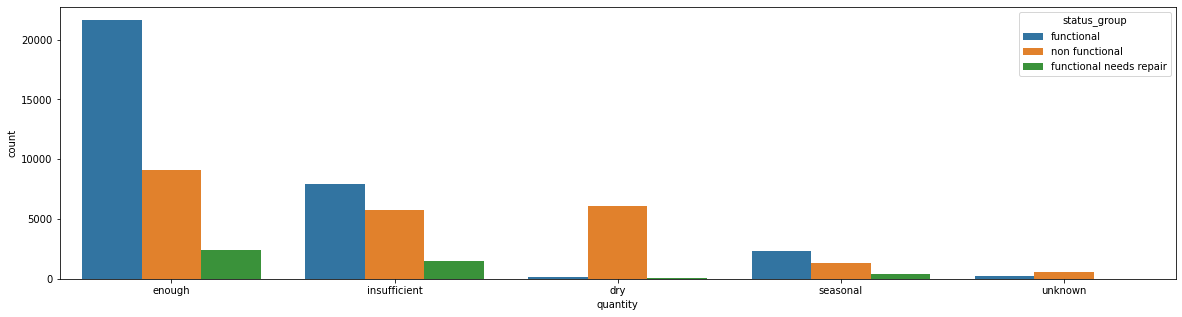

In [64]:
plt.figure(figsize=(20,5))
sns.countplot(data=df, x='quantity', hue='status_group')

### Source, source type and source class

In [65]:
print("Sources: ", df['source'].unique())
print("Source Types: ", df['source_type'].unique())
print("Source Classes: ", df['source_class'].unique())
df.groupby(['source_class', 'source_type', 'source'])['id'].count()

Sources:  ['spring' 'rainwater harvesting' 'dam' 'machine dbh' 'other'
 'shallow well' 'river' 'hand dtw' 'lake' 'unknown']
Source Types:  ['spring' 'rainwater harvesting' 'dam' 'borehole' 'other' 'shallow well'
 'river/lake']
Source Classes:  ['groundwater' 'surface' 'unknown']


source_class  source_type           source              
groundwater   borehole              hand dtw                 1108
                                    machine dbh             13822
              shallow well          shallow well            21140
              spring                spring                  21216
surface       dam                   dam                       840
              rainwater harvesting  rainwater harvesting     2863
              river/lake            lake                      950
                                    river                   11964
unknown       other                 other                     261
                                    unknown                    86
Name: id, dtype: int64

<AxesSubplot:xlabel='source', ylabel='count'>

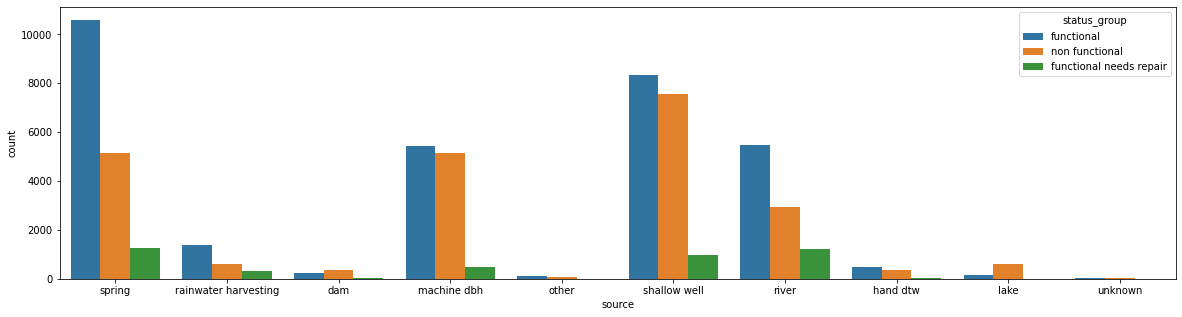

In [66]:
plt.figure(figsize=(20,5))
sns.countplot(data=df, x='source', hue='status_group')

### Waterpoint type and Waterpoint type group

In [67]:
df[df['waterpoint_type'] != df['waterpoint_type_group']]['waterpoint_type'].value_counts()

communal standpipe multiple    7611
Name: waterpoint_type, dtype: int64

So we can simply use only one of these two.

In [68]:
print(df['waterpoint_type'].value_counts())

communal standpipe             35628
hand pump                      21884
other                           8010
communal standpipe multiple     7611
improved spring                  959
cattle trough                    150
dam                                8
Name: waterpoint_type, dtype: int64


In [69]:
print(df['waterpoint_type_group'].value_counts())

communal standpipe    43239
hand pump             21884
other                  8010
improved spring         959
cattle trough           150
dam                       8
Name: waterpoint_type_group, dtype: int64


<AxesSubplot:xlabel='waterpoint_type', ylabel='count'>

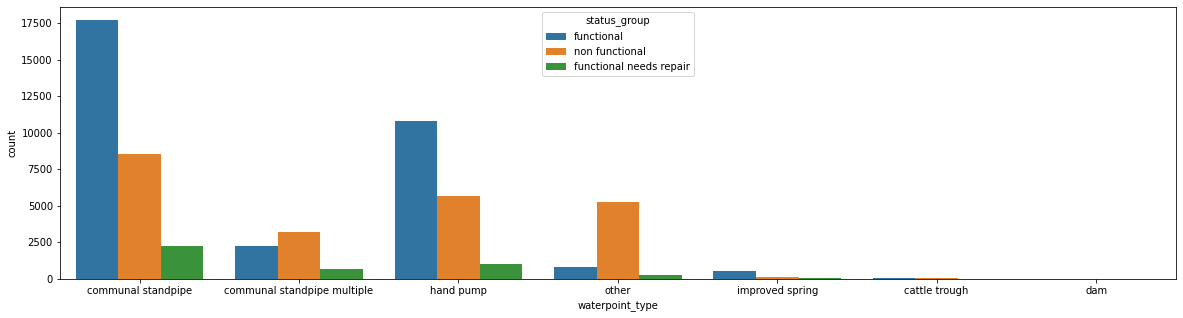

In [70]:
df_ = df.copy()
plt.figure(figsize=(20,5))
sns.countplot(data=df_, x='waterpoint_type', hue='status_group')

In [71]:
df.groupby(['waterpoint_type_group', 'waterpoint_type'])['id'].count()

waterpoint_type_group  waterpoint_type            
cattle trough          cattle trough                    150
communal standpipe     communal standpipe             35628
                       communal standpipe multiple     7611
dam                    dam                                8
hand pump              hand pump                      21884
improved spring        improved spring                  959
other                  other                           8010
Name: id, dtype: int64

## Preprocessing

In [72]:
train_X = pd.read_csv(DATA_DIR/'TrainData.csv')
train_Y = pd.read_csv(DATA_DIR/'TrainLabels.csv')
test_X = pd.read_csv(DATA_DIR/'TestData.csv')

train_test_X = train_X.append(test_X)
train_XY = train_X.merge(train_Y, left_on="id", right_on="id", how="outer")
train_test_XY = train_test_X.merge(train_Y, left_on="id", right_on="id", how="outer")

In [73]:
df = train_test_XY.copy()

### Text transformations

In [74]:
df['installer_text'] = clean_text(df['installer'])
df['funder_text'] = clean_text(df['funder'])

Reduced 2411 to 2130 columns
Reduced 2141 to 2141 columns


### Continous Variables

In [75]:
df['amount_tsh_missing'] = (df['amount_tsh'] == 0).astype(int)
df['amount_tsh_log_std'] = standardize(np.log(df['amount_tsh'] + 0.01))

df['population_missing'] = (df['population'] == 0).astype(int)
df['population_too_small'] = ((0 < df['population']) & (df['population'] < 10)).astype(int)
df['population_log_std'] = standardize(np.log(df['population'] + 0.01))

df['gps_height_std'] = standardize(df['gps_height'])

### Categorical Variables

In [76]:
cats = {}

df['funder_cat'], cats['funder'] = label_encode(df['funder'], low_count=100) # low_count=100
df['installer_cat'], cats['installer'] = label_encode(df['installer'])
df['basin_cat'], cats['basin'] = label_encode(df['basin']) 
df['region_cat'], cats['region'] = label_encode(df['region']) 
df['subvillage_cat'], cats['subvillage'] = label_encode(df['subvillage'], low_count=100)  # low_count=100

df['district_code_cat'], cats['district_code'] = label_encode(df['district_code'])
df['lga_cat'], cats['lga'] = label_encode(df['lga'], low_count=20)
df['ward_cat'], cats['ward'] = label_encode(df['ward'], low_count=10)
df['public_meeting_cat'], cats['public_meeting'] = label_encode(df['public_meeting'])

df['scheme_management_cat'], cats['scheme_management'] = label_encode(df['scheme_management'])
df['extraction_type_group_cat'], cats['extraction_type_group'] = label_encode(df['extraction_type_group'])
df['extraction_type_class_cat'], cats['extraction_type_class'] = label_encode(df['extraction_type_class'])
df['management_cat'], cats['management'] = label_encode(df['management'])
df['payment_cat'], cats['payment'] = label_encode(df['payment'])
df['quality_group_cat'], cats['quality_group'] = label_encode(df['quality_group'])
df['water_quality_cat'], cats['water_quality'] = label_encode(df['water_quality'])
df['quantity_cat'], cats['quantity'] = label_encode(df['quantity'])
df['source_cat'], cats['source'] = label_encode(df['source'])
df['waterpoint_type_cat'], cats['waterpoint_type'] = label_encode(df['waterpoint_type'])

df['status_group_cat'], cats['status_group'] = label_encode(df['status_group'])

In [77]:
df_proc = df.copy()

cat_cols = ['funder_cat', 'installer_cat', 'basin_cat', 'district_code_cat', 'region_cat', 'subvillage_cat', 'lga_cat', 'ward_cat',
            'public_meeting_cat', 'scheme_management_cat', 'extraction_type_group_cat', 'extraction_type_class_cat',
            'management_cat', 'payment_cat', 'quality_group_cat', 'water_quality_cat', 'quantity_cat', 'source_cat', 
            'waterpoint_type_cat', 

            'amount_tsh_missing', 'population_missing', 'population_too_small']
cont_cols = ['amount_tsh_log_std', 'population_log_std', 'gps_height_std',
            'longitude', 'latitude',
            ]

df_proc_train = df_proc[df_proc['status_group_cat'] != 3].copy()
df_proc_test = df_proc[df_proc['status_group_cat'] == 3].copy()

## Model Training

### Random Forest Model Training

In [78]:
df = df_proc_train.copy()
train_features, test_features, train_labels, test_labels = train_test_split(df[cat_cols + cont_cols], 
                                                            df['status_group_cat'], test_size=0.2, random_state=42)

print('Training Features Shape:', train_features.shape)
print('Training Labels Shape:', train_labels.shape)
print('Testing Features Shape:', test_features.shape)
print('Testing Labels Shape:', test_labels.shape)

Training Features Shape: (47520, 27)
Training Labels Shape: (47520,)
Testing Features Shape: (11880, 27)
Testing Labels Shape: (11880,)


#### Balance Dataset

In [79]:
from imblearn.over_sampling import RandomOverSampler

over_sampler = RandomOverSampler(random_state=42)
train_features_balanced, train_labels_balanced = over_sampler.fit_resample(train_features, train_labels)
print('Training Features Shape:', train_features_balanced.shape)
print('Training Labels Shape:', train_labels_balanced.shape)

Training Features Shape: (77406, 27)
Training Labels Shape: (77406,)


In [80]:
from imblearn.over_sampling import SMOTE

over_sampler = SMOTE(k_neighbors=2)
train_features_balanced, train_labels_balanced = over_sampler.fit_resample(train_features, train_labels)
print('Training Features Shape:', train_features_balanced.shape)
print('Training Labels Shape:', train_labels_balanced.shape)

Training Features Shape: (77406, 27)
Training Labels Shape: (77406,)


#### Run model

In [81]:
model = RandomForestClassifier(n_estimators=100, random_state=42, verbose=1)
model.fit(train_features, train_labels)
predictions = model.predict(test_features) 
print("Accuracy:",metrics.accuracy_score(test_labels, predictions))
print(metrics.classification_report(test_labels, predictions))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    7.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Accuracy: 0.8074915824915825
              precision    recall  f1-score   support

           0       0.81      0.88      0.85      6457
           1       0.52      0.35      0.42       851
           2       0.84      0.79      0.81      4572

    accuracy                           0.81     11880
   macro avg       0.72      0.67      0.69     11880
weighted avg       0.80      0.81      0.80     11880



[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.3s finished


Rerun, but without splitting to a validation set. Train on the whole dataset.

Current Best
- score = 0.8074915824915825
- validation set = 20%
- n_estimators = 200
- random_state = 42

Benchmark = 0.8074915824915825

#### Predict

Rerun, but without splitting to a validation set. Train on the whole dataset. (Note: Benchmark=0.80496632996633 on 20% validation set, 42 random state)

In [82]:
df = df_proc_train.copy()
all_features = df[cat_cols + cont_cols]
all_labels = df['status_group_cat']
model = RandomForestClassifier(n_estimators=200, random_state=42, verbose=1)
model.fit(all_features, all_labels)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:   18.1s finished


RandomForestClassifier(n_estimators=200, random_state=42, verbose=1)

In [83]:
df = df_proc_test.copy()
all_test_features = df[cat_cols + cont_cols]
predictions = model.predict(all_test_features)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.8s finished


In [84]:
label_preds = []
for idx, i in zip(test_X.id, predictions):
    label = cats['status_group'][i]
    label_preds.append([idx, label])
solution_df = pd.DataFrame(label_preds, columns=['id', 'status_group'])
solution_df.head()

,id,status_group
0,50785,non functional
1,51630,functional
2,17168,functional
3,45559,non functional
4,49871,functional


In [85]:
solution_df.to_csv("random-forest.csv", index=False)

### Fast.ai Tabular Model Training (Deep Learning)

In [86]:
df = df_proc_train.copy()
dls = ft.TabularDataLoaders.from_df(df, procs=[ft.Categorify], cat_names=cat_cols, cont_names=cont_cols, y_names="status_group", bs=256)
dls.show_batch()

,funder_cat,installer_cat,basin_cat,district_code_cat,region_cat,subvillage_cat,lga_cat,ward_cat,public_meeting_cat,scheme_management_cat,extraction_type_group_cat,extraction_type_class_cat,management_cat,payment_cat,quality_group_cat,water_quality_cat,quantity_cat,source_cat,waterpoint_type_cat,amount_tsh_missing,population_missing,population_too_small,amount_tsh_log_std,population_log_std,gps_height_std,longitude,latitude,status_group
0,85,1939,5,3,6,0,101,1726,1,11,1,0,7,0,2,6,2,8,1,1,0,0,-0.63634,0.924775,1.282308,37.968121,-4.499683e+00,functional
1,29,438,8,1,11,0,37,22,1,7,6,3,7,0,2,6,1,7,6,1,0,0,-0.63634,0.914243,-0.960890,37.136673,-6.188875e+00,non functional
2,46,894,1,6,10,35,63,342,1,7,5,1,7,5,2,6,1,7,4,1,1,0,-0.63634,-1.223835,-0.960890,32.897106,-9.243230e+00,non functional
3,20,442,6,4,3,0,92,520,1,8,9,4,10,5,2,6,1,1,4,1,0,0,-0.63634,0.764610,1.555129,35.008598,-9.265839e+00,functional
4,20,476,5,2,6,0,85,167,1,7,1,0,7,0,2,6,1,8,6,1,0,0,-0.63634,0.614987,1.061452,37.661751,-3.711309e+00,non functional
5,23,442,4,1,17,0,6,1388,2,9,5,1,11,6,2,6,1,7,4,1,1,0,-0.63634,-1.223835,-0.960890,0.000000,-2.000000e-08,functional
6,40,790,8,1,11,0,37,569,2,7,10,5,7,6,2,6,4,3,1,1,0,0,-0.63634,0.962415,-0.312759,37.135387,-6.781456e+00,non functional
7,30,442,0,2,0,0,1,1474,1,7,1,0,7,0,1,1,1,8,0,1,0,0,-0.63634,0.852138,1.286638,36.696793,-3.102546e+00,functional
8,0,610,4,2,9,0,103,1320,0,0,10,5,0,0,4,4,1,3,1,1,0,0,-0.63634,0.614987,0.853588,34.406990,-2.124258e+00,functional
9,77,442,3,3,17,0,26,71,1,12,6,3,11,6,3,3,2,7,6,1,1,0,-0.63634,-1.223835,-0.960890,32.230137,-4.010892e+00,functional


In [87]:
learn = ft.tabular_learner(dls, metrics=ft.accuracy)
learn.fit_one_cycle(10)

epoch,train_loss,valid_loss,accuracy,time
0,0.841290,0.698503,0.743771,00:02
1,0.578835,0.569436,0.773232,00:02
2,0.511456,0.536939,0.782492,00:02
3,0.475538,0.538831,0.781650,00:02
4,0.451084,0.529622,0.789731,00:02
5,0.411974,0.541832,0.788468,00:02
6,0.388805,0.548611,0.793771,00:02
7,0.358302,0.557297,0.792593,00:02
8,0.333270,0.570106,0.792845,00:02
9,0.315758,0.571575,0.791162,00:02


Rerun, but without splitting to a validation set. Train on the whole dataset.

In [88]:
df = df_proc_train.copy()
dls = ft.TabularDataLoaders.from_df(df, procs=[ft.Categorify], cat_names=cat_cols, cont_names=cont_cols, y_names="status_group", bs=256, valid_idx=[])
learn = ft.tabular_learner(dls)
learn.fit_one_cycle(10)

epoch,train_loss,valid_loss,time
0,0.771606,None,00:02
1,0.562533,None,00:02
2,0.507716,None,00:02
3,0.477016,None,00:02
4,0.449116,None,00:02
5,0.414267,None,00:02
6,0.389473,None,00:02
7,0.355275,None,00:02
8,0.332900,None,00:02
9,0.325692,None,00:02


/home/kdsuneraavinash/.virtualenvs/ml-project-pump-it-up/lib/python3.9/site-packages/fastprogress/fastprogress.py:74: UserWarning: Your generator is empty.
  warn("Your generator is empty.")


In [89]:
test_df = df_proc_test.copy()
dl = learn.dls.test_dl(test_df[cat_cols + cont_cols])

In [90]:
preds, _ = learn.get_preds(dl=dl)

In [91]:
label_preds = []
for idx, i in zip(test_X.id, preds.argmax(axis=1)):
    label = cats['status_group'][i]
    label_preds.append([idx, label])
solution_df = pd.DataFrame(label_preds, columns=['id', 'status_group'])
solution_df.head()

,id,status_group
0,50785,non functional
1,51630,functional
2,17168,functional
3,45559,non functional
4,49871,functional


Score: 80.13%

In [92]:
solution_df.to_csv("fastai-nn.csv", index=False)

### Custom NN Training

In [93]:
# TODO

### XGBoost Model Training

In [94]:
# TODO

## Postprocessing

In [95]:
# TODO